In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5py

In [2]:
import scipy.spatial as spatial

In [3]:
f_001 = h5py.File('comoving-observations.h5', 'r')

In [4]:
dset001 = f_001['pos']

In [5]:
N = len(dset001)

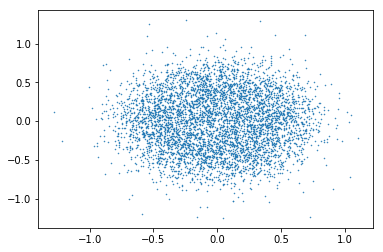

In [6]:
plt.plot(dset001[:,0],dset001[:,1],'.',markersize=1)
plt.show()

# LS estimator

First create a random dataset with the same radial extentent. In order to get the same footrpint, I randomly perturb the dataset the same way the observations are drawn from the positions

In [8]:
def normalize(v):
    return v / np.sqrt(np.sum(v*v))

def draw_observation(xyz):
    x, y, z = xyz
    d = np.sqrt(np.sum(xyz*xyz))
    
    rhat = normalize(xyz)
    
    v = np.random.randn(3)
    vp = v - np.dot(rhat, v)*rhat
    xhat = normalize(vp)
    yhat = np.cross(xhat, rhat)
    
    T_rxy_to_xyz = np.row_stack((rhat, xhat, yhat))
    
    sigma_r = (0.3 + 0.15*np.random.random())*d
    sigma_x = np.exp(np.log(6*np.pi/180) + 0.5*np.random.randn())*d
    sigma_y = np.exp(np.log(10*np.pi/180) + 0.5*np.random.randn())*d
    
    Sigma = np.dot(T_rxy_to_xyz, np.dot(np.diag((sigma_r*sigma_r, sigma_x*sigma_x, sigma_y*sigma_y)),\
                                        T_rxy_to_xyz.T))
    
    xyz_obs = xyz + np.dot(np.linalg.cholesky(Sigma), np.random.randn(3))
    
    return xyz_obs

I generate four estimator random data sets in order to have a crude estimate of the statistics

In [9]:
Nr=100000
rc = 0.77
Rset_v1 = (2.0*np.random.rand(2*Nr, 3)-1.0)*rc
radii = np.sum(Rset_v1**2,axis=1)
radsel = radii < rc**2
Rset_v2 = Rset_v1[radsel]
Rset1 = Rset_v2[:Nr]

Rset1r = np.zeros((Nr,3))
for i in range(Nr):
    Rset1r[i] = draw_observation(Rset1[i])
    
Rset_v1 = (2.0*np.random.rand(2*Nr, 3)-1.0)*rc
radii = np.sum(Rset_v1**2,axis=1)
radsel = radii < rc**2
Rset_v2 = Rset_v1[radsel]
Rset2 = Rset_v2[:Nr]

Rset2r = np.zeros((Nr,3))
for i in range(Nr):
    Rset2r[i] = draw_observation(Rset2[i])

Rset_v1 = (2.0*np.random.rand(2*Nr, 3)-1.0)*rc
radii = np.sum(Rset_v1**2,axis=1)
radsel = radii < rc**2
Rset_v2 = Rset_v1[radsel]
Rset3 = Rset_v2[:Nr]

Rset3r = np.zeros((Nr,3))
for i in range(Nr):
    Rset3r[i] = draw_observation(Rset3[i])

Rset_v1 = (2.0*np.random.rand(2*Nr, 3)-1.0)*rc
radii = np.sum(Rset_v1**2,axis=1)
radsel = radii < rc**2
Rset_v2 = Rset_v1[radsel]
Rset4 = Rset_v2[:Nr]

Rset4r = np.zeros((Nr,3))
for i in range(Nr):
    Rset4r[i] = draw_observation(Rset4[i])

In order to get the pairwise distances the KD tree is useful tool

In [10]:
dtree001 = spatial.cKDTree(dset001)
rtree1 = spatial.cKDTree(Rset1r)
rtree2 = spatial.cKDTree(Rset2r)
rtree3 = spatial.cKDTree(Rset3r)
rtree4 = spatial.cKDTree(Rset4r)

In [11]:
bins = np.arange(0.00,0.4,0.02)
bins

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38])

These compute the histograms of pairwise distances

In [20]:
# Data-Data distances
dd001cts = dtree001.count_neighbors(dtree001,bins)
print("Done with DD")

# Random-Random distances
rr1cts = rtree1.count_neighbors(rtree1,bins)
print("Done with RR1")
rr2cts = rtree2.count_neighbors(rtree2,bins)
print("Done with RR2")
rr3cts = rtree3.count_neighbors(rtree3,bins)
print("Done with RR3")
rr4cts = rtree4.count_neighbors(rtree4,bins)
print("Done with RR4")

# Data-Random distances 
dr001cts1 = dtree001.count_neighbors(rtree1,bins)
print("Done with DR1")
dr001cts2 = dtree001.count_neighbors(rtree2,bins)
print("Done with DR2")
dr001cts3 = dtree001.count_neighbors(rtree3,bins)
print("Done with DR3")
dr001cts4 = dtree001.count_neighbors(rtree4,bins)
print("Done with DR4")

We need to normalize the histograms correctly

In [29]:
dd001 = np.diff(dd001cts)/N/(N-1)*2.0

dr0011 = np.diff(dr001cts1)/N/Nr
dr0012 = np.diff(dr001cts2)/N/Nr
dr0013 = np.diff(dr001cts3)/N/Nr
dr0014 = np.diff(dr001cts4)/N/Nr

rr1 = np.diff(rr1cts)/Nr/(Nr-1)*2.0
rr2 = np.diff(rr2cts)/Nr/(Nr-1)*2.0
rr3 = np.diff(rr3cts)/Nr/(Nr-1)*2.0
rr4 = np.diff(rr4cts)/Nr/(Nr-1)*2.0

Look at the distribution of the 4 different results i.e. construct four different LS estimators and look at their mean and variance. This is probably not quite correct, but the best I can think of.

In [40]:
ls001d = np.array([(dd001-2.0*dr0011+rr1)/rr1-1,(dd001-2.0*dr0012+rr2)/rr2-1,\
                 (dd001-2.0*dr0013+rr3)/rr3-1,(dd001-2.0*dr0014+rr4)/rr4-1])

In [41]:
ls001var=np.sqrt(np.var(ls001d,axis=0))
ls001mean=np.mean(ls001d,axis=0)

In [42]:
dx = 0.01
cens = bins[:-1]+dx

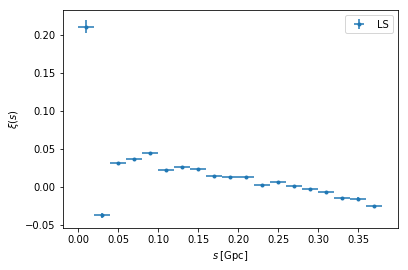

In [45]:
plt.errorbar(cens,ls001mean,fmt='.',xerr=dx,yerr=ls001var,label="LS")
plt.legend()
plt.xlabel(r'$s\;[\mathrm{Gpc}]$')
plt.ylabel(r'$\xi(s)$')
plt.show()